# Roadmap
1. 特徵萃取 (學姊) (含濾波歸一化) 不用生理資訊(BMI、AGE)
2. ttest
3. 標準化
4. SVM


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import SVC
from sklearn.model_selection import ParameterSampler, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

#scipy
import scipy.stats

#sql
import pymysql

#warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("VA_after_norm.csv")
# df = df.drop(columns=["date", 'No'])
label = df['Label']
feature = df.drop(columns= 'Label')
feature.head()

,No,date,baseline_HBO,baseline_HHB,baseline_TSI,Stage1_HBO,Stage1_HHB,Stage1_TSI,Stage2_HBO,Stage2_HHB,...,Stage2_HBT,Stage3_HBT,Stage4_HBT,Stage5_HBT,baseline_s_HBT,Stage1_s_HBT,Stage2_s_HBT,Stage3_s_HBT,Stage4_s_HBT,Stage5_s_HBT
0,16,20190411,0.546827,0.213108,0.623036,0.848909,0.672988,0.727131,0.928770,0.520833,...,0.784216,0.745137,0.831077,0.962319,0.768102,0.872249,0.306117,0.431027,0.767076,0.536624
1,18,20190417,0.686992,0.523408,0.418815,0.328046,0.887768,0.285901,0.638969,0.468428,...,0.629863,0.828427,0.913089,0.459101,0.440172,0.909003,0.117851,0.392379,0.268949,0.716088
2,18,20190419,1.000000,0.264996,0.694523,0.486160,0.799860,0.463201,0.537074,0.968256,...,0.853411,0.716727,0.568179,0.517108,0.588180,0.768014,0.600648,0.424007,0.529334,0.486141
3,25,20190611,0.496084,0.635033,0.611456,0.700639,0.808147,0.397692,1.000000,0.439566,...,0.815773,0.518276,0.202995,0.449327,0.767482,0.994784,0.190574,0.286855,0.476695,0.524319
4,25,20190613,0.086049,0.814283,0.231377,0.289291,0.794955,0.354758,0.372669,0.763486,...,0.326743,0.233183,0.341006,0.859813,0.382502,0.739077,0.676325,0.368637,0.826626,1.000000


In [3]:
df.groupby('No').count()['date']

No
12    2
16    1
18    2
22    2
23    2
25    3
27    1
28    2
32    1
36    2
38    4
39    1
40    6
41    2
42    2
43    3
44    1
45    4
Name: date, dtype: int64

In [4]:
def acc_plot(data_fea, data_label, train_fea, train_label,  model, h = 0.02, bound= 1,  **params):

    # plot function
    #===========================================#
    #用途: 畫出邊界plot

    #切記: 二維才能畫圖
    #===========================================#
    # Import: 
    # numpy
    # matplotlib.pyplot
    #===========================================#

    plt.style.use('seaborn-white')

    if len(data_fea.columns) == 2:
        def make_meshgrid(x1, x2, h = h):
            x_min, x_max = x1.min() - bound, x1.max() + bound
            y_min, y_max = x2.min() - bound, x2.max() + bound
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(clf, xx, yy, ax, **params ):
            z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  #np.c_ 帥爛
            z = z.reshape(xx.shape)
            ax.contourf(xx, yy, z, alpha= 0.8, cmap = plt.cm.coolwarm)
            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            
        sns.set(font_scale=1.4)

        fig, (ax2, ax1) = plt.subplots(1, 2, figsize= (12, 6))
        xx, yy = make_meshgrid(data_fea.iloc[:, 0],  data_fea.iloc[:, 1])
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax1,  **params)
        ax1.scatter(data_fea.iloc[:, 0], data_fea.iloc[:, 1], c= data_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax1.set_xlabel(data_fea.columns[0])
        ax1.set_ylabel(data_fea.columns[1])
        ax1.set_title(f"VA Group {model.__class__.__name__} Accuracy: {accuracy_score(test_labels, model.predict(data_fea)):.3f} (Test)")
        # plt.show()

        # plt.figure(figsize= (6, 6))
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax2, **params)
        ax2.scatter(train_fea.iloc[:, 0], train_fea.iloc[:, 1], c= train_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax2.set_xlabel(train_fea.columns[0])
        ax2.set_ylabel(train_fea.columns[1])
        ax2.set_title(f"VA Group {model.__class__.__name__} Accuracy: {accuracy_score(train_label, model.predict(train_fea)):.3f} (Train)")
        plt.tight_layout()
        plt.show()

    else: 
        print("Data should be two dimension!!")

        pass

    #==================R=O=C===================================================#

In [15]:
def condusion_m(test_fea, test_label, model, plot= True, types= "Test"):

    #=============================
    # 用途: 
    #     製造出confusion matrix

    # Parameter:
    #     test_fea  就feature
    #     test_label  就label
    #     model  就model
    #=============================

    from sklearn.metrics import confusion_matrix
    
    conf = confusion_matrix(test_label, model.predict(test_fea))
    conp = np.array([(x/sum(x)) for x in conf])

    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14, 7))
    # 重點是 annot，cmap='Blues'
    if plot:
        sns.set(font_scale=1.8)
        sns.heatmap(conp , annot= True, cmap='Blues', xticklabels= ['LOW', 'HIGH'], yticklabels=['LOW', 'HIGH'])
        plt.title(f"Confusion Matrix of VA Group ({types})")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        sns.heatmap(conf , annot= True, cmap='Blues', xticklabels= ['LOW', 'HIGH'], yticklabels=['LOW', 'HIGH'])
        plt.title(f"Confusion Matrix of VA Group ({types})")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    sensitivity = recall_score(test_label, model.predict(test_fea))
    precision = precision_score(test_label, model.predict(test_fea))
    return sensitivity, precision

    

In [16]:
def ROCP(test_fea, test_label, model, a= 0, pos_label= 0):
    from sklearn.metrics import roc_curve, auc

    #=============================
    # 用途: 
    #     製造出confusion matrix

    # Parameter:
    #     test_fea  就feature
    #     test_label  就label
    #     model  就model
    #     a= 0 如果auc很奇怪，就 =1 
    #=============================

    try:
        prob = model.predict_proba(test_fea)[:, a]
        sns.set(font_scale=1.4)
        fig, ax= plt.subplots(1, 1, figsize= (8, 7))

        
        fpr, tpr, thresholds = roc_curve(test_label, prob, pos_label= pos_label)  #pos_label= 0 要設值
        plt.plot(fpr, tpr,   color= 'b', linewidth=3.0)

        
        x, y = np.arange(0, 1, 0.01), np.arange(0, 1, 0.01)
        plt.plot(x, y, '-.', linewidth=3.0, label= f"AUC  = {auc(fpr, tpr)}", color= 'r')
        
        ax.set_xlabel(" 1 - specificity")
        ax.set_ylabel("Sensitivity")
        ax.set_title(f"{model.__class__.__name__}'s  ROC")
        plt.legend()
        plt.show()
    
    except:
        print("Can't print ROC")

In [7]:
def ttttest(train_fea, train_label):

    #======================================================
    # 1. scipy.stats.shapiro


    shap_low = []
    shap_high = []
    shap_cols = []

    all_fea = train_fea.merge(train_label, left_index= True, right_index= True)
    # all_fea = all_fea.sort_values(by= train_label.name)

    # print(train_label.name)

    cols = all_fea.columns
    #print(cols)

    all_low = all_fea[all_fea[train_label.name] == 0]
    all_high = all_fea[all_fea[train_label.name] == 1]

    for col in cols:
        # 看p_value 可不留
        lows = scipy.stats.shapiro(all_low[col])[1]
        highs = scipy.stats.shapiro(all_high[col])[1]

        shap_low.append(lows)
        shap_high.append(highs)

        if lows > 0.05 and highs > 0.05:
            shap_cols.append(col)

    shap_cols
    #=====================================================
    # 2.scipy.stats.levene

    levene = []
    good_levene = []

    for shapiro_col in shap_cols:

        lev = scipy.stats.levene(all_low[shapiro_col], all_high[shapiro_col], center = 'mean')[1]  
        levene.append(lev)

        if lev > 0.05:
            good_levene.append(shapiro_col)

    good_levene

    #======================================================
    # 3. scipy.stats.ttest_ind
    
    ttest = []
    good_ttest = []


    for good_lev in good_levene:
        ttestn = scipy.stats.ttest_ind(all_low[good_lev], all_high[good_lev], equal_var = True)[1]
        ttest.append(ttestn)

    #display results
    ttest_df = pd.Series(ttest, index= good_levene, name= train_label.name + '_T_score').sort_values()
    return ttest_df

In [8]:
# StarifiedKfold
def Starifieds(df_feature_cl, pure_feature, random_state= 42, n_splits= 4, shuffle= True):

    #======================================
    # 用處: Starifieds Kflod 原本只能出index，這裡二合一
    #
    # Parameter: 
    #     df_feature_cl, feature
    #     pure_feature, label
    #     random_state= 42, 不必多說
    #     n_splits= 4,  分幾份
    #     shuffle= True  如字面上
    #======================================

    xtrain, xtest = list(StratifiedKFold(n_splits= n_splits, shuffle= shuffle, random_state= random_state).split(df_feature_cl, pure_feature))[0]
    train_fea, test_fea = df_feature_cl.iloc[xtrain], df_feature_cl.iloc[xtest]
    train_label, test_label = pure_feature.iloc[xtrain], pure_feature.iloc[xtest]

    #===============
    

    try:
        train_fea.drop(columns= ["Gender"], inplace=True)
        test_fea.drop(columns= ["Gender"], inplace=True)
    except:
        pass
    
    return train_fea, train_label, test_fea, test_label



In [9]:
train_fea, train_label, test_fea, test_label = Starifieds(feature, label, random_state=40, n_splits=4, shuffle= True)

for rand in range(40):
    train_fea2, train_label2, test_fea2, test_label2 = train_fea, train_label, test_fea, test_label = Starifieds(feature, label, random_state=rand, n_splits=4, shuffle= True)

    cbi2 = ttttest(train_fea2, train_label2)
    # print(cbi2)
    if cbi2[0] < 0.05 and cbi2[1] < 0.05:
        print("rand ", rand, "\n", cbi2[:2], end= '\n\n')

rand  0 
 Stage3_different_HHB     0.006384
Stage5_activation_HHB    0.011503
Name: Label_T_score, dtype: float64

rand  1 
 Stage3_different_HHB     0.008031
Stage3_activation_HHB    0.027845
Name: Label_T_score, dtype: float64

rand  2 
 Stage3_different_HHB    0.006863
Stage5_HBT              0.034763
Name: Label_T_score, dtype: float64

rand  3 
 Stage4_activation_HHB    0.014021
Stage1_different_HBO     0.019343
Name: Label_T_score, dtype: float64

rand  4 
 Stage3_different_HBO     0.000928
Stage4_activation_HHB    0.010165
Name: Label_T_score, dtype: float64

rand  5 
 Stage3_different_HBO    0.001071
Stage3_different_HHB    0.001817
Name: Label_T_score, dtype: float64

rand  7 
 Stage3_different_HBO     0.013698
Stage5_activation_HHB    0.019787
Name: Label_T_score, dtype: float64

rand  8 
 Stage5_activation_HHB    0.001808
Stage1_s_HBO             0.013745
Name: Label_T_score, dtype: float64

rand  10 
 Stage5_HHB               0.008574
Stage5_activation_HHB    0.008954
Name:

In [10]:
conn = pymysql.connect(host= '127.0.0.1', port= 3306, user= 'root', passwd='boil', charset= 'utf8', db= 'svm')
cursor = conn.cursor()

In [11]:
# cursor.close()
# conn.close()

In [12]:
time_string = str(pd.to_datetime('today').replace(microsecond = 0)).replace(" ", "").replace("-", "").replace(":", "")

create_command = '''CREATE table VA{}(ID INT AUTO_INCREMENT, feature_1 varchar(1000), p_value_feature_1 decimal(8, 4), feature_2 varchar(1000), p_value_feature_2 decimal(8, 4), rand int, train_score decimal(8, 4), test_score decimal(8, 4), gamma decimal(8, 4), C decimal(8, 4),sensitivity decimal(8, 4), precision_col decimal(8, 4), PRIMARY KEY (ID))default charset= utf8;'''.format(time_string)

cursor.execute(create_command)
conn.commit()


In [21]:
for iui in range(2000):
    print(iui, end= " ")
    train_feas, train_labels, test_feas, test_labels = Starifieds(feature, label, random_state=iui, n_splits=4, shuffle= True)
    # try:
    cbi2 = ttttest(train_feas, train_labels)
    if cbi2[0] < 0.05 and cbi2[1] < 0.05:
        
        train_feas, test_feas = train_feas[cbi2.index[:2]], test_feas[cbi2.index[:2]]

        train_f1 = train_feas.columns[0]
        train_f2 = train_feas.columns[1]

        # ====================
        # print(train_feas.columns)
        for imm in train_feas.columns:
            if 'std' not in imm:     
                sd = StandardScaler()
                train_feasn = sd.fit_transform(train_feas[imm].values.reshape(-1,1))
                test_feasn = sd.transform(test_feas[imm].values.reshape(-1,1))

                train_feas[imm] = train_feasn
                test_feas[imm] = test_feasn

                # print(f'trans {imm}')
        # print(test_feas)
        # ===================================

        
        param_grid = {"C": [0.01, 0.1, 1, 10, 100], "gamma":[0.01, 0.1, 1, 5]}

        param_list = list(ParameterSampler(param_grid, n_iter=10000))

        for par in param_list:
            csc = SVC(probability=True, **par)                              
            csc.fit(train_feas, train_labels)
            train_s = accuracy_score(train_labels, csc.predict(train_feas))
            test_s = accuracy_score(test_labels, csc.predict(test_feas))



            if test_s  >= 0.795 and train_s  >= 0.795 and test_s < 0.95 and train_s < 0.95:                
                # print('rand = ', iui)
                # print(cbi2)
                
                # print("train ", gc.best_score_)
                # print('train ', train_s)
                # print('test', test_s)
                # print("par = ", par)

                cmrr = condusion_m(test_feas, test_labels, csc, False)
                sensitivity = cmrr[0]
                precision = cmrr[1]

                cursor.execute("INSERT INTO VA{}(feature_1, p_value_feature_1, feature_2, p_value_feature_2, rand, train_score, test_score, gamma, C, sensitivity, precision_col) values('{}', {}, '{}', {}, {}, {}, {}, {}, {}, {}, {})".format(time_string, train_f1, cbi2[0], train_f2, cbi2[1], iui, train_s, test_s, par['gamma'], par['C'], sensitivity, precision, str(cbi2)))
                conn.commit()

                # acc_plot(test_feas, test_labels, train_feas, train_labels, csc)
                
                # ROCP(test_feas, test_labels, csc, a= 0)
    # except:
    #     pass



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 rand =  22
Stage5_activation_HHB    0.013979
Stage5_HHB               0.018717
Stage1_s_HBO             0.067624
Stage4_activation_HHB    0.075220
baseline_HBT             0.090341
Stage1_different_HHB     0.094194
Stage1_activation_HHB    0.094194
Stage3_s_HBT             0.096373
Stage2_different_HBO     0.100981
Stage3_activation_HHB    0.123155
Stage1_s_HBT             0.180949
baseline_HHB             0.183330
Stage4_different_HHB     0.187337
Stage4_s_HBT             0.213262
Stage1_HBO               0.219969
Stage5_different_HHB     0.225182
Stage3_different_HBO     0.226773
Stage5_s_HHB             0.334232
Stage5_TSI               0.378422
Stage2_HBT               0.411849
Stage2_different_HHB     0.462306
Stage3_TSI               0.487069
Stage3_HHB               0.506344
Stage2_activation_HHB    0.511080
Stage2_HHB               0.521242
Stage3_HBO               0.587470
Stage5_s_HBO             0.599767
Stage1_s_HHB

In [62]:
plt.cm.coolwarm(1000)

(0.705673158, 0.01555616, 0.150232812, 1.0)

In [85]:
def acc_plot(data_fea, data_label, train_fea, train_label,  model, h = 0.02, bound= 1,  **params):
    from matplotlib.patches import Patch

    # plot function
    #===========================================#
    #用途: 畫出邊界plot

    #切記: 二維才能畫圖
    #===========================================#
    # Import: 
    # numpy
    # matplotlib.pyplot
    #===========================================#

    plt.style.use('seaborn-white')

    if len(data_fea.columns) == 2:
        def make_meshgrid(x1, x2, h = h):
            x_min, x_max = x1.min() - bound, x1.max() + bound - 0.5
            y_min, y_max = x2.min() - bound, x2.max() + bound - 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(clf, xx, yy, ax, **params ):
            z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  #np.c_ 帥爛
            z = z.reshape(xx.shape)
            ax.contourf(xx, yy, z, alpha= 0.8, cmap = plt.cm.coolwarm)
            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            
        sns.set(font_scale=1.4)
        legend_elements = [Patch(facecolor=(0.2298057, 0.298717966, 0.753683153), label='Low'), Patch(facecolor=(0.705673158, 0.01555616, 0.150232812), label='High')]

        fig, (ax2, ax1) = plt.subplots(1, 2, figsize= (12, 6))
        xx, yy = make_meshgrid(data_fea.iloc[:, 0],  data_fea.iloc[:, 1])
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax1,  **params)
        ax1.scatter(data_fea.iloc[:, 0], data_fea.iloc[:, 1], c= data_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax1.set_xlabel(data_fea.columns[0])
        ax1.set_ylabel(data_fea.columns[1])
        ax1.set_title(f"VA Group {model.__class__.__name__} Accuracy: {accuracy_score(test_labels, model.predict(data_fea)):.3f} (Test)")
        ax1.legend(handles=legend_elements, loc= 2)

        # plt.show()

        # plt.figure(figsize= (6, 6))
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax2, **params)
        ax2.scatter(train_fea.iloc[:, 0], train_fea.iloc[:, 1], c= train_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax2.set_xlabel(train_fea.columns[0])
        ax2.set_ylabel(train_fea.columns[1])
        ax2.set_title(f"VA Group {model.__class__.__name__} Accuracy: {accuracy_score(train_label, model.predict(train_fea)):.3f} (Train)")
        plt.tight_layout()    

        # Create the figure

        ax2.legend(handles=legend_elements, loc= 2)


        # plt.legend()
        plt.show()

    else: 
        print("Data should be two dimension!!")

        pass

    #==================R=O=C===================================================#

0.8666666666666667 0.8181818181818182


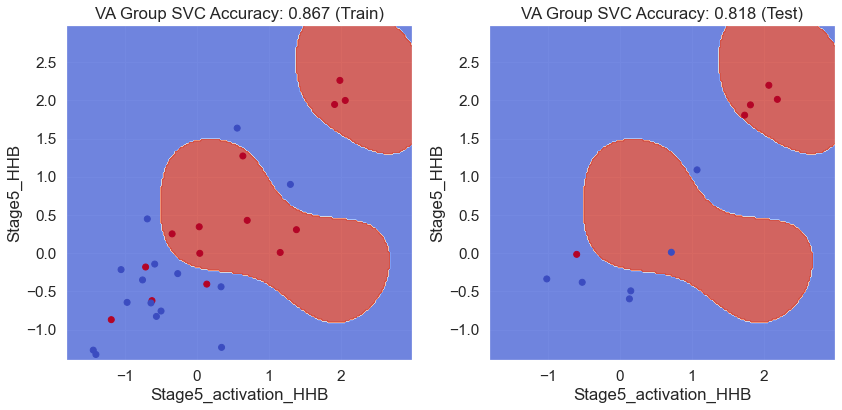

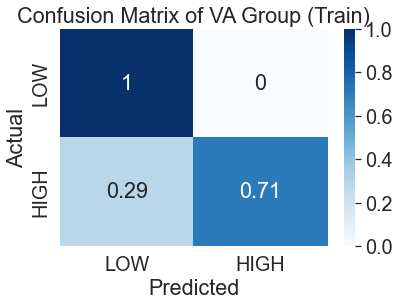

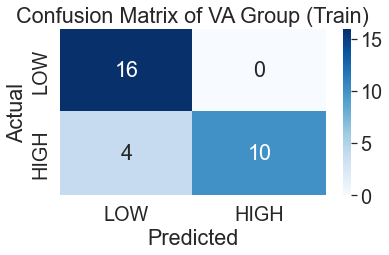

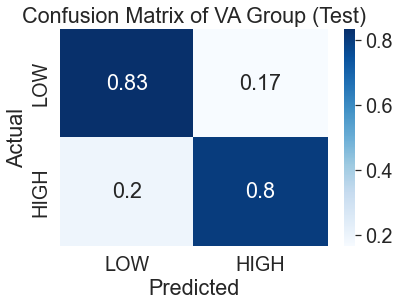

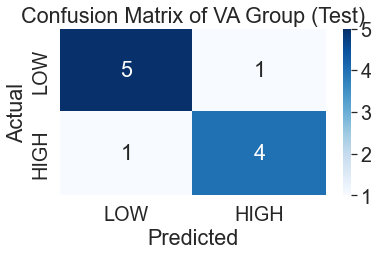

sensitivity, precision :  (0.8, 0.8)


In [17]:
#　| 126 | Stage4_activation_HHB |            0.0229 | Stage1_s_HBO          |            0.0365 |  279 |      0.8667 |     0.8182 | 1.0000 |   1.0000 |      0.8000 |        0.8000 |

# | 150 | Stage5_HHB            |            0.0113 | Stage1_HBO            |            0.0246 |  307 |      0.8667 |     0.8182 | 1.0000 |  10.0000 |      0.8000 |        0.8000 |

# | 155 | Stage5_HHB            |            0.0097 | Stage5_activation_HHB |            0.0107 |  337 |      0.8667 |     0.8182 | 5.0000 |   1.0000 |      0.8000 |        0.8000 |


# | 162 | Stage5_activation_HHB |            0.0070 | Stage5_HHB            |            0.0131 |  347 |      0.8667 |     0.8182 | 5.0000 |   1.0000 |      0.8000 |        0.8000 |
# | 167 | Stage5_activation_HHB |            0.0071 | Stage5_HHB            |            0.0125 |  360 |      0.8667 |     0.8182 | 5.0000 |   1.0000 |      0.8000 |        0.8000 |

# | 168 | Stage5_activation_HHB |            0.0071 | Stage5_HHB            |            0.0125 |  360 |      0.8667 |     0.8182 | 1.0000 |  10.0000 |      0.8000 |        0.8000 |
# | 169 | Stage5_activation_HHB |            0.0071 | Stage5_HHB            |            0.0125 |  360 |      0.8667 |     0.8182 | 1.0000 | 100.0000 |      0.8000 |        0.8000 |
# | 177 | Stage3_different_HHB  |            0.0143 | baseline_HHB          |            0.0261 |  383 |      0.8667 |     0.8182 | 1.0000 |  10.0000 |      0.8000 |        0.8000 |
# | 188 | Stage5_activation_HHB |            0.0067 | Stage3_different_HBO  |            0.0238 |  429 |      0.8667 |     0.8182 | 0.1000 | 100.0000 |      0.8000 |        0.8000 |


train_feas, train_labels, test_feas, test_labels = Starifieds(feature, label, random_state=360 , n_splits=4, shuffle= True)

train_feas, test_feas = train_feas[["Stage5_activation_HHB", "Stage5_HHB"]], test_feas[["Stage5_activation_HHB", "Stage5_HHB"]]

# ====================
# print(train_feas.columns)
for imm in train_feas.columns:  
    if 'std' not in imm:     
        sd = StandardScaler()
        train_feasn = sd.fit_transform(train_feas[imm].values.reshape(-1,1))
        test_feasn = sd.transform(test_feas[imm].values.reshape(-1,1))

        train_feas[imm] = train_feasn
        test_feas[imm] = test_feasn

    # print(f'trans {imm}')
# print(test_feas)
# ===================================



csc = SVC(probability=True, gamma= 1, C= 10)                          

#gc = GridSearchCV(csc, params, cv= 5, n_jobs= -1, scoring= 'accuracy')
csc.fit(train_feas, train_labels)
train_s = accuracy_score(train_labels, csc.predict(train_feas))
test_s = accuracy_score(test_labels, csc.predict(test_feas))
print(train_s, test_s)

acc_plot(test_feas, test_labels, train_feas, train_labels, csc, bound= 0.8)
condusion_m(train_feas, train_labels, csc, types = 'Train')
cm_cr = condusion_m(test_feas, test_labels, csc)
print('sensitivity, precision : ', cm_cr)